# VES Experiments for 2D Bayesian Optimization

In [26]:
from ves import *
import matplotlib.pyplot as plt
import numpy as np
import torch

Maximizer is  tensor([1., 1.])


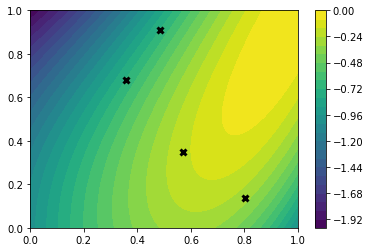

In [208]:
train_X = torch.rand(4, 2, dtype=torch.double)
def f(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    return (-1 * (y - x**2)**2 - (1 - x)**2)
train_Y = f(train_X).reshape(-1,1)
bounds = torch.zeros(2,2)
bounds[:, 1] = torch.ones(2)

# plot function f
nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f(X)

plt.contourf(Xx, Xy, f((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])

In [210]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.sampling.pathwise import draw_matheron_paths
NUM_PATHS = 1000
outcome_transform = Standardize(m=1)
gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
_ = fit_gpytorch_mll(mll) # fit mll hyperpara
best_f = train_Y.max()
paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
model = VariationalEntropySearch(gp, bounds=bounds, best_f=best_f, paths=paths)


In [211]:
kvals, betavals, ei, val = model(X, return_ves=True)

Maximizer of EI is  tensor(0.6000) tensor(0.2800)
Maximizer of VES is  tensor(0.5700) tensor(0.3100)


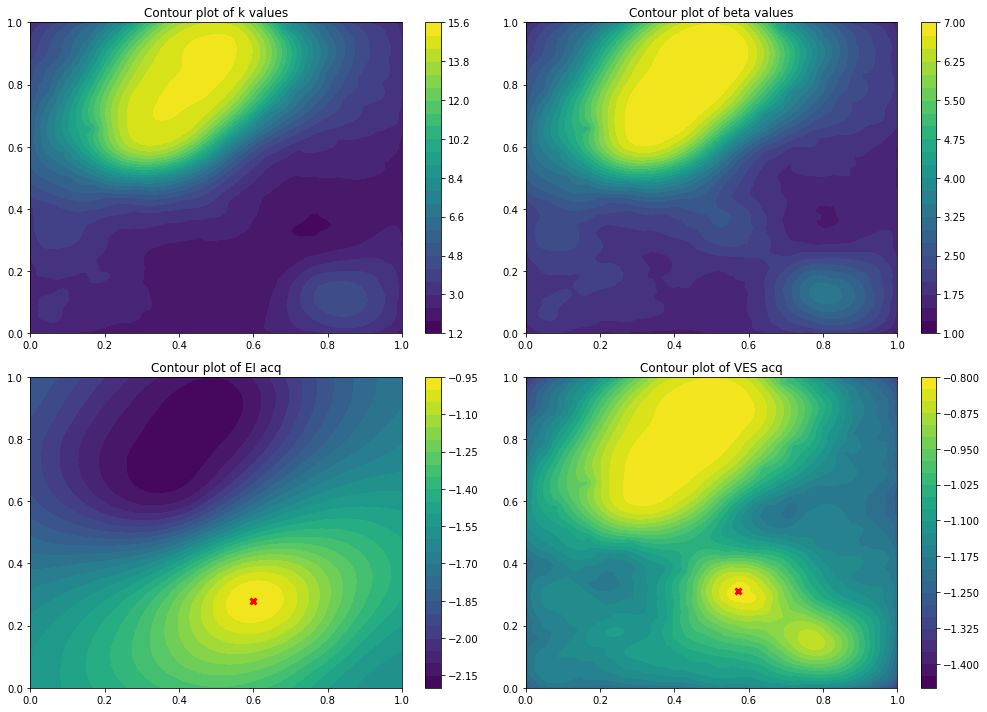

In [212]:
einp = ei.reshape(nx,ny).detach().numpy()
eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
print('Maximizer of EI is ',Xx[eix,eiy],Xy[eix,eiy])
valnp = val.reshape(nx,ny).detach().numpy()
valx, valy = np.unravel_index(np.argmax(valnp, axis=None), valnp.shape)
print('Maximizer of VES is ',Xx[valx,valy],Xy[valx,valy])

fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Create a 2x2 grid of subplots

# Contour plots
cs1 = axs[0, 0].contourf(Xx, Xy, kvals.reshape(nx,ny).detach().numpy(), 25)
cs2 = axs[0, 1].contourf(Xx, Xy, betavals.reshape(nx,ny).detach().numpy(), 25)
cs3 = axs[1, 0].contourf(Xx, Xy, ei.reshape(nx,ny).detach().numpy(), 25)
axs[1, 0].plot(Xx[eix,eiy], Xy[eix,eiy], 'kx', mew=3, c='r')
cs4 = axs[1, 1].contourf(Xx, Xy, val.reshape(nx,ny).detach().numpy(), 25)
axs[1, 1].plot(Xx[valx,valy], Xy[valx,valy], 'kx', mew=3, c='r')

# Adding colorbars and titles for each subplot
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Contour plot of k values')

fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Contour plot of beta values')

fig.colorbar(cs3, ax=axs[1, 0])
axs[1, 0].set_title('Contour plot of EI acq')

fig.colorbar(cs4, ax=axs[1, 1])
axs[1, 1].set_title('Contour plot of VES acq')

plt.tight_layout()  # Adjust the layout
plt.show()

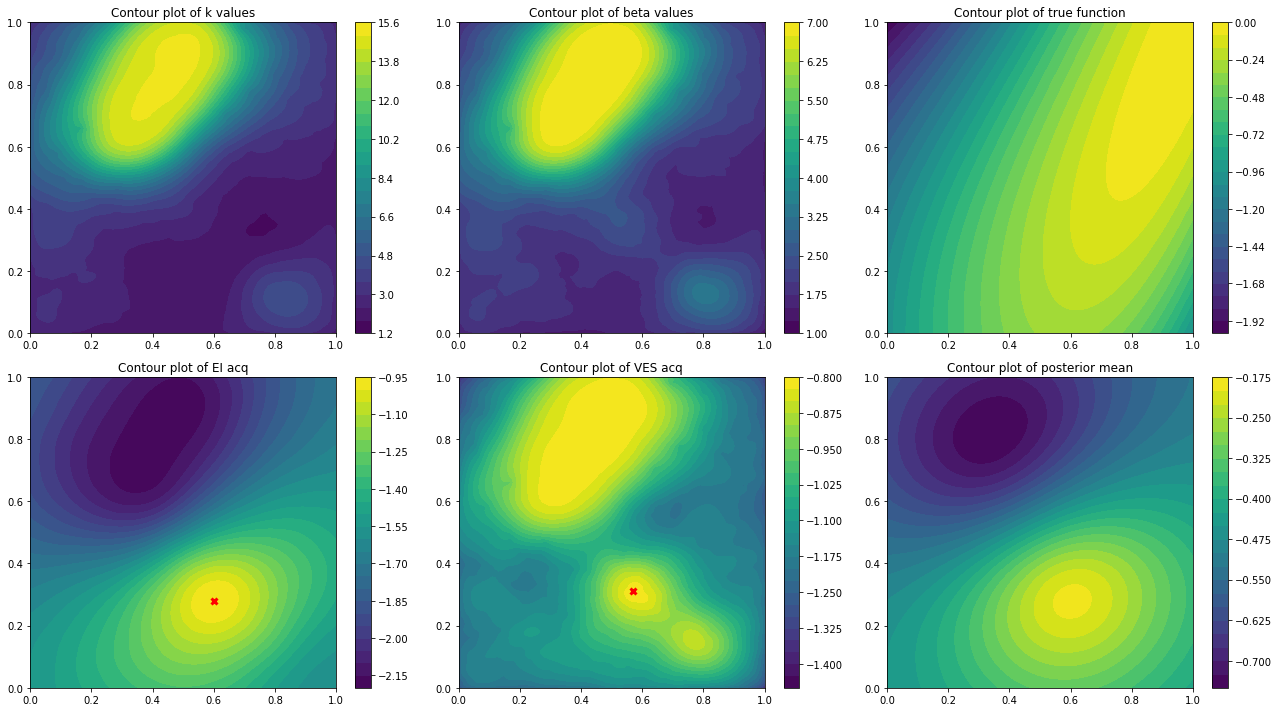

In [213]:
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
with torch.no_grad():
    ks, betas, ei, val = model(X, return_ves=True)
einp = ei.reshape(nx,ny).detach().numpy()
eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)

valnp = val.reshape(nx,ny).detach().numpy()
valx, valy = np.unravel_index(np.argmax(valnp, axis=None), valnp.shape)

pmean = model.model.posterior(X).mean.reshape(nx,ny).detach().numpy()

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Create a 2x2 grid of subplots

# Contour plots
cs1 = axs[0, 0].contourf(Xx, Xy, ks.reshape(nx,ny).detach().numpy(), 25)
cs2 = axs[0, 1].contourf(Xx, Xy, betas.reshape(nx,ny).detach().numpy(), 25)
cs3 = axs[0, 2].contourf(Xx, Xy, f((Xx, Xy)).detach().numpy(), 25)
cs4 = axs[1, 0].contourf(Xx, Xy, ei.reshape(nx,ny).detach().numpy(), 25)
axs[1, 0].plot(Xx[eix,eiy], Xy[eix,eiy], 'kx', mew=3, c='r')
cs5 = axs[1, 1].contourf(Xx, Xy, val.reshape(nx,ny).detach().numpy(), 25)
axs[1, 1].plot(Xx[valx,valy], Xy[valx,valy], 'kx', mew=3, c='r')
cs6 = axs[1, 2].contourf(Xx, Xy, pmean, 25)

# Adding colorbars and titles for each subplot
fig.colorbar(cs1, ax=axs[0, 0])
axs[0, 0].set_title('Contour plot of k values')

fig.colorbar(cs2, ax=axs[0, 1])
axs[0, 1].set_title('Contour plot of beta values')

fig.colorbar(cs3, ax=axs[0, 2])
axs[0, 2].set_title('Contour plot of true function')

fig.colorbar(cs4, ax=axs[1, 0])
axs[1, 0].set_title('Contour plot of EI acq')

fig.colorbar(cs5, ax=axs[1, 1])
axs[1, 1].set_title('Contour plot of VES acq')

fig.colorbar(cs6, ax=axs[1, 2])
axs[1, 2].set_title('Contour plot of posterior mean')

plt.tight_layout()  # Adjust the layout

## Start BO Iteratively

Maximizer is  tensor([1., 1.])


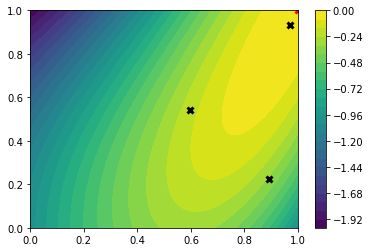

In [182]:
from tqdm import tqdm
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
# Iterative optimization
num_iter = 20
num_samp = 10
init_points = 3
train_X_st = torch.rand(init_points, 2, dtype=torch.double)
train_Y_st = f(train_X_st).reshape(-1,1)
train_X, train_Y = train_X_st, train_Y_st

nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f(X)

plt.contourf(Xx, Xy, f((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])
plt.plot(X[torch.argmax(Y)][0], X[torch.argmax(Y)][1], 'kx', mew=3, c='r')

In [183]:
# VES Iteration
ves_ep, ei_ep = [], []
for _ in tqdm(range(num_samp)):
    # Initialize points
    train_X_st = torch.rand(init_points, 2, dtype=torch.double)
    train_Y_st = f(train_X_st).reshape(-1,1)
    train_X, train_Y = train_X_st, train_Y_st

    reg_ves_ep = []
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_ep.append(best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        einp = ei.reshape(nx,ny).detach().numpy()
        eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
        new_x = torch.tensor([[Xx[eix,eiy],Xy[eix,eiy]]])
        new_y = f(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])
    # EI Iteration
    reg_ei_ep = []
    train_Y_st = f(train_X_st).reshape(-1,1)
    train_X, train_Y = train_X_st, train_Y_st
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ei_ep.append(best_f.item())
        EI = ExpectedImprovement(model=gp, best_f=best_f)
        new_x, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([[0.0] * 2, [1.0] * 2]),
            q=1,
            num_restarts=20,
            raw_samples=100,
            options={},
        )
        new_y = f(new_x).reshape(-1,1)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    ves_ep.append(reg_ves_ep)
    ei_ep.append(reg_ei_ep)

100%|██████████| 10/10 [48:47<00:00, 292.80s/it]


## Branin-Hoo function
Reference: https://www.sfu.ca/~ssurjano/branin.html
$$f(x_1, x_2)=\frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1-5)^2}{4\pi^2}+\frac{5(15x_1-5)}{\pi}-6\right)^2+\left(10-\frac{10}{8\pi}\right)\cos(15x_1-5)-44.81\right]$$

In [185]:
def f_bh(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    return -((15*y-5.1*(15*x-5)/(4*torch.pi)+5*(15*x-5)/torch.pi-6)**2
            +(10-10/(8*torch.pi))*torch.cos(15*x-5)-44.81)/51.95

Maximizer is  tensor([0.5400, 0.1500])


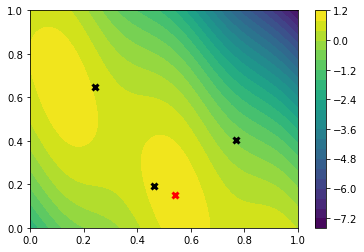

In [186]:
train_X = torch.rand(init_points, 2, dtype=torch.double)
train_Y = f_bh(train_X).reshape(-1,1)
bounds = torch.zeros(2,2)
bounds[:, 1] = torch.ones(2)

# plot function f
nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f_bh(X)

plt.contourf(Xx, Xy, f_bh((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])
plt.plot(X[torch.argmax(Y)][0], X[torch.argmax(Y)][1], 'kx', mew=3, c='r')

In [187]:
# Iterative optimization
train_X_st = torch.rand(init_points, 2, dtype=torch.double)
train_Y_st = f_bh(train_X_st).reshape(-1,1)
train_X, train_Y = train_X_st, train_Y_st

nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T

ves_bh, ei_bh = [], []
for _ in tqdm(range(num_samp)):
    # Initialize points
    train_X_st = torch.rand(init_points, 2, dtype=torch.double)
    train_Y_st = f_bh(train_X_st).reshape(-1,1)
    train_X, train_Y = train_X_st, train_Y_st

    # VES Iteration
    reg_ves_bh = []
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_bh.append(best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        einp = ei.reshape(nx,ny).detach().numpy()
        eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
        new_x = torch.tensor([[Xx[eix,eiy],Xy[eix,eiy]]])
        new_y = f_bh(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])

    # EI Iteration
    reg_ei_bh = []
    train_X, train_Y = train_X_st, train_Y_st
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ei_bh.append(best_f.item())
        EI = ExpectedImprovement(model=gp, best_f=best_f)
        new_x, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([[0.0] * 2, [1.0] * 2]),
            q=1,
            num_restarts=20,
            raw_samples=100,
            options={},
        )
        new_y = f_bh(new_x).reshape(-1,1)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    ves_bh.append(reg_ves_bh)
    ei_bh.append(reg_ei_bh)

100%|██████████| 10/10 [58:40<00:00, 352.06s/it]


## Goldstein-Price function
Reference: https://www.sfu.ca/~ssurjano/goldpr.html
$$f(x_1, x_2) = \frac{1}{2.427}\left[\log\left([1+(x+y+1)^2(19-14x+3x^2-14y+6xy+3y^2)][30+(2x-3y)^2(18-32x+12x^2+48y-36xy+27y^2)]\right)-8.693\right],$$
where $x=4x_1-2$, $y=4x_2-2$.

In [189]:
def f_gp(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    x = 4*x-2
    y = 4*y-2
    return -(torch.log((1+(x+y+1)**2
                       *(19-14*x+3*x**2-14*y+6*x*y+3*y**2))
                       *(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2)))
                       -8.693)/2.427

Maximizer is  tensor([0.5000, 0.2500])


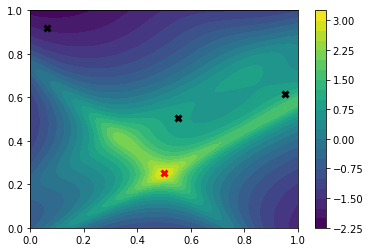

In [190]:
train_X = torch.rand(init_points, 2, dtype=torch.double)
train_Y = f_gp(train_X).reshape(-1,1)
bounds = torch.zeros(2,2)
bounds[:, 1] = torch.ones(2)

# plot function f
nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f_gp(X)

plt.contourf(Xx, Xy, f_gp((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])
plt.plot(X[torch.argmax(Y)][0], X[torch.argmax(Y)][1], 'kx', mew=3, c='r')

In [191]:
# Iterative optimization
train_X_st = torch.rand(init_points, 2, dtype=torch.double)
train_Y_st = f_gp(train_X_st).reshape(-1,1)
train_X, train_Y = train_X_st, train_Y_st

nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T

ves_gp, ei_gp = [], []
for _ in tqdm(range(num_samp)):
    # Initialize points
    train_X_st = torch.rand(init_points, 2, dtype=torch.double)
    train_Y_st = f_gp(train_X_st).reshape(-1,1)
    train_X, train_Y = train_X_st, train_Y_st
    
    # VES Iteration
    reg_ves_gp = []
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_gp.append(best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        einp = ei.reshape(nx,ny).detach().numpy()
        eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
        new_x = torch.tensor([[Xx[eix,eiy],Xy[eix,eiy]]])
        new_y = f_gp(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])

    # EI Iteration
    reg_ei_gp = []
    train_X, train_Y = train_X_st, train_Y_st
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ei_gp.append(best_f.item())
        EI = ExpectedImprovement(model=gp, best_f=best_f)
        new_x, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([[0.0] * 2, [1.0] * 2]),
            q=1,
            num_restarts=20,
            raw_samples=100,
            options={},
        )
        new_y = f_gp(new_x).reshape(-1,1)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    ves_gp.append(reg_ves_gp)  
    ei_gp.append(reg_ei_gp)

100%|██████████| 10/10 [1:03:18<00:00, 379.81s/it]


## Rosenbrock function
Reference: https://en.wikipedia.org/wiki/Rosenbrock_function
$$f(x_1,x_2) = -(1-x_1)^2-100(x_2-x_1^2)^2$$

In [193]:
def f_rs(X):
    if isinstance(X, tuple):
        x,y = X
    elif X.ndim != 2:
        x,y = X[0],X[1]
    else:
        x,y = X[:,0],X[:,1]
    x = 4 * x - 2
    y = 4 * y - 1
    return -(1-x)**2-100*(y-x**2)**2

Maximizer is  tensor([0.7500, 0.5000])


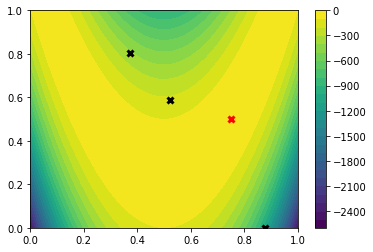

In [194]:
train_X = torch.rand(init_points, 2, dtype=torch.double)
train_Y = f_rs(train_X).reshape(-1,1)
bounds = torch.zeros(2,2)
bounds[:, 1] = torch.ones(2)

# plot function f
nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T
Y = f_rs(X)

plt.contourf(Xx, Xy, f_rs((Xx,Xy)),25)
plt.colorbar()
plt.plot(train_X[:,0], train_X[:,1], 'kx', mew=3)
print('Maximizer is ',X[torch.argmax(Y)])
plt.plot(X[torch.argmax(Y)][0], X[torch.argmax(Y)][1], 'kx', mew=3, c='r')

In [195]:
# Iterative optimization
train_X_st = torch.rand(init_points, 2, dtype=torch.double)
train_Y_st = f_rs(train_X_st).reshape(-1,1)
train_X, train_Y = train_X_st, train_Y_st

nx,ny = 101,101 # grid size for x and y
X1,X2 = torch.linspace(bounds[0,0],bounds[0,1],nx),torch.linspace(bounds[1,0],bounds[1,1],ny)
Xx,Xy = torch.meshgrid(X1,X2)
X = torch.vstack((Xx.flatten(),Xy.flatten())).T

ves_rs, ei_rs = [], []
for _ in tqdm(range(num_samp)):
    # Initialize points
    train_X_st = torch.rand(init_points, 2, dtype=torch.double)
    train_Y_st = f_rs(train_X_st).reshape(-1,1)
    train_X, train_Y = train_X_st, train_Y_st
    
    # VES Iteration
    reg_ves_rs = []
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_rs.append(best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        einp = ei.reshape(nx,ny).detach().numpy()
        eix, eiy = np.unravel_index(np.argmax(einp, axis=None), einp.shape)
        new_x = torch.tensor([[Xx[eix,eiy],Xy[eix,eiy]]])
        new_y = f_rs(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])

    # EI Iteration
    reg_ei_rs = []
    train_X, train_Y = train_X_st, train_Y_st
    for t in range(num_iter):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ei_rs.append(best_f.item())
        EI = ExpectedImprovement(model=gp, best_f=best_f)
        new_x, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([[0.0] * 2, [1.0] * 2]),
            q=1,
            num_restarts=20,
            raw_samples=100,
            options={},
        )
        new_y = f_rs(new_x).reshape(-1,1)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    ves_rs.append(reg_ves_rs)
    ei_rs.append(reg_ei_rs)

100%|██████████| 10/10 [46:43<00:00, 280.30s/it]


In [197]:
ei_ep = np.asarray(ei_ep)
ves_ep = np.asarray(ves_ep)
ei_bh = np.asarray(ei_bh)
ves_bh = np.asarray(ves_bh)
ei_gp = np.asarray(ei_gp)
ves_gp = np.asarray(ves_gp)
ei_rs = np.asarray(ei_rs)
ves_rs = np.asarray(ves_rs)
ei_ep_mean = np.mean(ei_ep, axis=0)
ei_ep_std = np.std(ei_ep, axis=0)
ves_ep_mean = np.mean(ves_ep, axis=0)
ves_ep_std = np.std(ves_ep, axis=0)
ei_bh_mean = np.mean(ei_bh, axis=0)
ei_bh_std = np.std(ei_bh, axis=0)
ves_bh_mean = np.mean(ves_bh, axis=0)
ves_bh_std = np.std(ves_bh, axis=0)
ei_gp_mean = np.mean(ei_gp, axis=0)
ei_gp_std = np.std(ei_gp, axis=0)
ves_gp_mean = np.mean(ves_gp, axis=0)
ves_gp_std = np.std(ves_gp, axis=0)
ei_rs_mean = np.mean(ei_rs, axis=0)
ei_rs_std = np.std(ei_rs, axis=0)
ves_rs_mean = np.mean(ves_rs, axis=0)
ves_rs_std = np.std(ves_rs, axis=0)

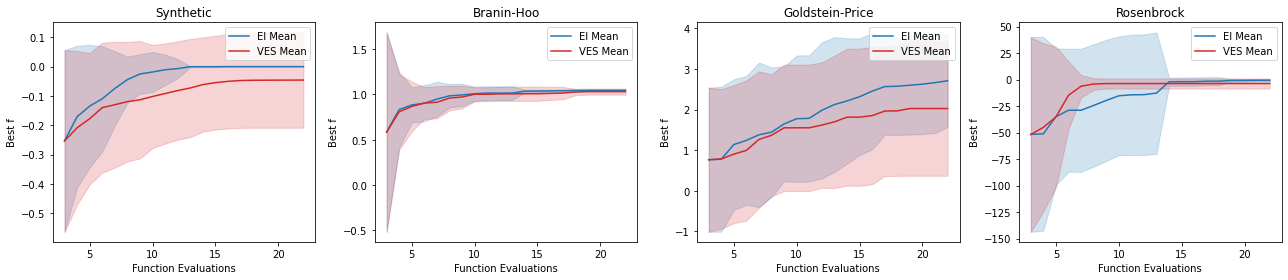

In [202]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))  # Create a 1x4 grid of subplots
names = ['Synthetic', 'Branin-Hoo', 'Goldstein-Price', 'Rosenbrock']
data = [(ei_ep_mean, ei_ep_std, ves_ep_mean, ves_ep_std), 
        (ei_bh_mean, ei_bh_std, ves_bh_mean, ves_bh_std),
        (ei_gp_mean, ei_gp_std, ves_gp_mean, ves_gp_std),
        (ei_rs_mean, ei_rs_std, ves_rs_mean, ves_rs_std)]
for i in range(4):
    ei_mean, ei_std, ves_mean, ves_std = data[i]
    axs[i].plot(np.arange(len(ves_mean))+init_points, ei_mean, label='EI Mean', c='tab:blue')
    axs[i].fill_between(np.arange(len(ei_mean))+init_points, ei_mean-1.94*ei_std, ei_mean+1.94*ei_std, color='tab:blue', alpha=0.2)
    axs[i].plot(np.arange(len(ves_mean))+init_points, ves_mean, label='VES Mean', c='tab:red')
    axs[i].fill_between(np.arange(len(ves_mean))+init_points, ves_mean-1.94*ves_std, ves_mean+1.94*ves_std, color='tab:red', alpha=0.2)
    axs[i].legend()
    axs[i].set_xlabel('Function Evaluations')
    axs[i].set_ylabel('Best f')
    axs[i].set_title(names[i])
plt.tight_layout()  # Adjust the layout